# Environment Set Up

The code below downloads the relevant `skpro` development branch from github and install it.

It also "corrects" the version of `pymc` that comes pre-installed on Google Colab.

Note: after running the above cell, remember to restart the session for the changes to take effect.

# Introduction

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skpro.regression.bayesian import BayesianLinearRegressor

In [2]:
%load_ext autoreload
%autoreload 2

This notebook serves to demonstrate the use of the `skpro`'s `BayesianLinearRegressor` regressor. This class implements Bayesian linear regression using `PyMC` as a backend. It assumes weakly-informative Bayesian priors for both the intercepts and slopes of the model.

Compared to a traditional OLS Linear Regression,  Bayesian Linear Regression offers several benefits:

1. It provides full posterior distributions of model parameters, allowing for direct assessment of uncertainty in predictions.
2. It enables the inclusion of prior information or beliefs about parameters, improving estimates when data is limited.
3. It regularizes parameter estimates through priors, reducing overfitting compared to traditional linear regression.


## Data Generation

We will first create synthetic data with just one feature (`feature1`) and 50 data points. The true relationship between the data $\mathbf{x}$ and the target variable ($y_{\text{true}}$) is given by the equation:

\begin{equation}
y_{\text{true}} = \text{intercept}_{\text{true}} + \mathbf{x} \cdot \mathbf{m}_{\text{true}}
\end{equation}


where $\text{intercept}_{\text{true}} = 1$ and $\mathbf{m}_{\text{true}} = 2$.

The observed target values ($y_{\text{train}}$) are generated by adding Gaussian noise to the true target values:

\begin{equation}
y = y_{\text{true}} + \mathcal{N}(0, \sigma_{\text{true}})
\end{equation}
Here, $\sigma_{\text{true}} = 0.5$.


In [3]:
N = 50
np.random.seed(42)
# Creating 50 random data points containing 1 feature
feature1 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1})

# Set the relationship between the feature and the target variable
TRUE_INTERCEPT = 1
TRUE_SLOPES = np.array([2])
TRUE_SIGMA = 0.5

# Calculating the true target variable
y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)
y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

# Combine the features and targets into a single DataFrame
train_data = pd.concat(
    [X_train, pd.Series(y_true, name="y_true"), pd.Series(y_train, name="y_train")],
    axis=1,
)
train_data = train_data.sort_values(by="feature1")
train_data = train_data.reset_index(drop=True)

# Display the train_data DataFrame
train_data.head()

,feature1,y_true,y_train
0,0.020584,1.041169,1.203211
1,0.034389,1.068777,1.807724
2,0.046450,1.092901,0.770341
3,0.058084,1.116167,0.885848
4,0.065052,1.130103,1.112190


The line chart below plots the relationship between `feature1` and the targets - both the theoretical `y_true`, represented by the red line, and the observed `y_train`, represented by the blue dots.

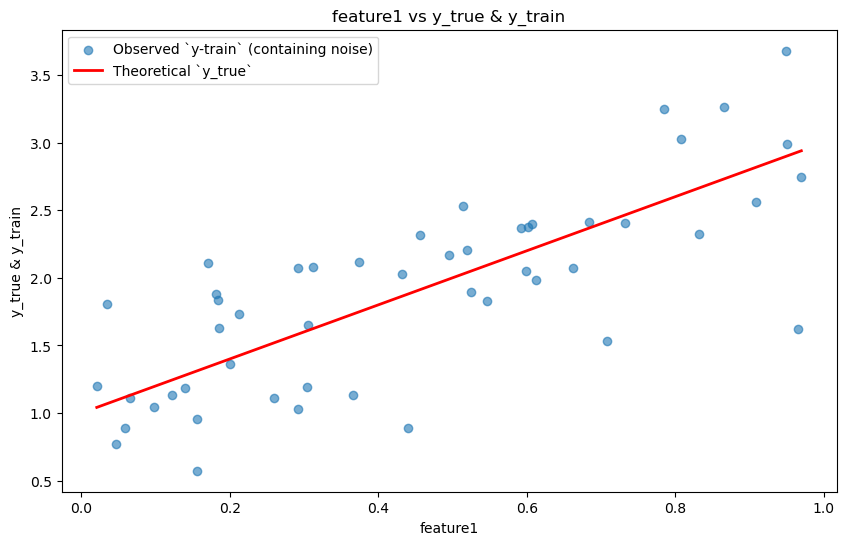

In [4]:
# Plot feature1 vs true_target
plt.figure(figsize=(10, 6))
plt.scatter(
    train_data["feature1"],
    train_data["y_train"],
    label="Observed `y-train` (containing noise)",
    alpha=0.6,
)
plt.plot(
    train_data["feature1"],
    train_data["y_true"],
    color="red",
    label="Theoretical `y_true`",
    linewidth=2,
)
plt.xlabel("feature1")
plt.ylabel("y_true & y_train")
plt.title("feature1 vs y_true & y_train")
plt.legend()
plt.show()

We will also create synthetic testing data to evaluate the models' performance on new, unseen data points. The following code generates 30 new testing data points.

In [5]:
# Generate new data points for prediction
N_test = 30
X_test = pd.DataFrame({"feature1": np.linspace(0, 1, N_test)})
X_test.head()

,feature1
0,0.000000
1,0.034483
2,0.068966
3,0.103448
4,0.137931


# OLS

To determine the relationship between the features and the target variable, we will train and inspect a model.

First, we'll train an Ordinary Least Squares (OLS) regression model using the `statsmodels` library.

In [6]:
import statsmodels.api as sm

# Fit a linear regression model using statsmodels
X_train_with_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_with_const).fit()

When fitted to the data, the `ols_model` above use maximum likelihood to find estimates of the model parameters. A downside of this approach is that it only gives point estimates - that is, single values for the slope and intercept without providing information about the distribution of these estimates.


The code below shows how we can extract out the estimated parameters from `ols_model`. As we can see, the point estimates for the slopes, intercept, and standard deviation are quite close to the true values we set earlier.

In [7]:
y_train_pred = ols_model.predict(X_train_with_const)
residuals = y_train_pred - y_train

# Print the true model and estimated model
print("True data generating model:")
print(f"y_true = {TRUE_SLOPES[0]:.2f}x + {TRUE_INTERCEPT:.2f}")
print(f"True standard deviation: {TRUE_SIGMA}\n")

print("Estimated MLE model:")
print(f"y_hat = {ols_model.params.iloc[1]:.2f}x + {ols_model.params.iloc[0]:.2f}")
print(f"Standard deviation of residuals: {residuals.std():.2f}")

True data generating model:
y_true = 2.00x + 1.00
True standard deviation: 0.5

Estimated MLE model:
y_hat = 1.89x + 1.05
Standard deviation of residuals: 0.46



Using the trained `ols_model`,  we can also create point predictions on the unseen `X_test` along with the corresponding confidence interval. The latter provides a range within which we expect the true parameter to lie with a certain level of confidence (e.g., 95%).

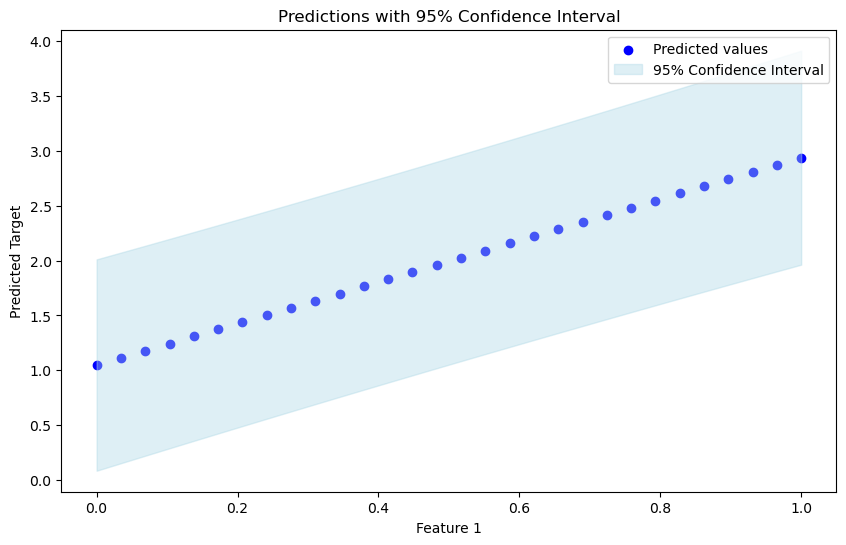

In [8]:
# Predict y_test using the linear model
X_test_with_const = sm.add_constant(X_test)
predictions = ols_model.get_prediction(X_test_with_const)
pred_summary = predictions.summary_frame(alpha=0.05)

# Extract predicted values and confidence intervals
y_test_pred = pred_summary["mean"]
conf_int_lower = pred_summary["obs_ci_lower"]
conf_int_upper = pred_summary["obs_ci_upper"]

# Plot the predictions with the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test["feature1"], y_test_pred, color="blue", label="Predicted values")
plt.fill_between(
    X_test["feature1"],
    conf_int_lower,
    conf_int_upper,
    color="lightblue",
    alpha=0.4,
    label="95% Confidence Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title("Predictions with 95% Confidence Interval")
plt.legend()
plt.show()

# Bayesian Inference

Now let's switch our attention to bayesian linear regression. Bayesian linear regression estimates the relationship between variables by incorporating prior knowledge or beliefs along with the observed data. Instead of providing single point estimates for the model parameters (like the slope and intercept), it calculates their probability distributions.

`skpro` provides an implementation of Bayesian linear regression through the `BayesianLinearRegressor` class. Here, we create an instance of the `BayesianLinearRegressor` and fit it to our training data.

In [9]:
y_train = pd.DataFrame(y_train)
y_train.columns = ["target"]

In [10]:
bayes_model = BayesianLinearRegressor()
bayes_model.default_prior_config

{'intercept': Prior("Normal", mu=0, sigma=10),
 'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id"),
 'noise_var': Prior("InverseGamma", alpha=3, beta=1)}

In [11]:
%timeit
bayes_model.fit(X_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/data/inference_data.py:1538: UserWarning: The group training_data is not defined in the InferenceData scheme
  warnings.warn(


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=0, sigma=10),
                                      'noise_var': Prior("InverseGamma", alpha=3, beta=1),
                                      'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

## Theory

In this section, we will explore the theoretical framework used in Bayesian linear regression.

Bayesian linear regression directly applies Bayes' Theorem to estimate the posterior distributions of the model parameters. As a reminder, here is the Bayes Theorem:

\begin{align*}
P(\theta \mid D) &= \frac{P(D \mid \theta) \times P(\theta)}{P(D)} \\
\text{posterior} &= \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}
\end{align*}


Where:

- $\theta$ represents the model parameters, which in our case consist of the intercept $\beta_{0}$, the slopes $\beta$ and the noise $\sigma$
- $D$ represents the observed training data, which consist of $\mathbf{X}_{\text{train}}$ and  $\mathbf{y}_{\text{train}}$
- $P(\theta \mid D)$ is the posterior distribution of the parameters - given the data.
- $P(D \mid \theta)$ is the likelihood of the data given the parameters.
- $P(\theta)$ is the prior distribution of the parameters.
- $P(D)$ is the marginal likelihood (evidence), a normalizing constant ensuring the posterior is a valid probability distribution.



### Prior

The prior $P(\theta)$ reflects our beliefs about the parameters before observing any data. In our case, since we don't have any strong beliefs about the parameters, we shall use weekly informative priors for our parameters:

\begin{align*}
\text{intercept} &== \beta_{0} &\sim \mathcal{N}(0, 10) \\
\text{slopes} &== \beta &\sim \mathcal{N}(0, 10) \\
\text{noise} &== \sigma &\sim \text{InverseGamma}(\alpha=3, \beta=1)
\end{align*}


These priors are the default that are specified when we instantiate our model: `BayesianLinearRegressor()`; we can inspect them using the `default_prior_config` attribute of the model instance.

In [12]:
bayes_model.default_prior_config

{'intercept': Prior("Normal", mu=0, sigma=10),
 'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id"),
 'noise_var': Prior("InverseGamma", alpha=3, beta=1)}

Should we want to modify these priors, we'll need to supply a similarly-structured dictionary of priors during model instantiation.

We can extract the prior through the `sample_prior` method of the `bayes_model`. We see that these prior distributions match the distributions we set during model instantiation.

Sampling: [intercept, noise_var, slopes, y_obs]


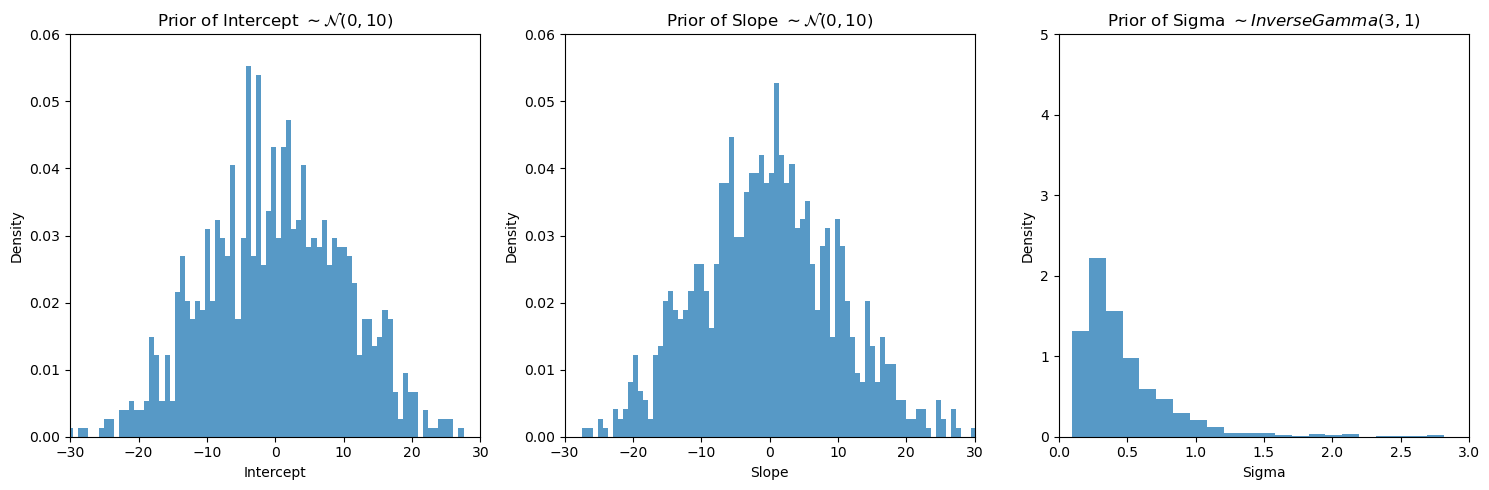

In [13]:
# get the prior samples as a dictionary of numpy arrays
prior_samples = bayes_model.sample_prior("numpy")

# Plot the prior distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot prior for intercept
axes[0].hist(prior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].set_title(r"Prior of Intercept $\sim \mathcal{N}(0, 10)$")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")
axes[0].set_xlim(left=-30, right=30)
axes[0].set_ylim(top=0.06, bottom=0)

# Plot prior for slope
axes[1].hist(prior_samples["slopes"], bins=80, density=True, alpha=0.75)
axes[1].set_title(r"Prior of Slope $\sim \mathcal{N}(0, 10)$")
axes[1].set_xlabel("Slope")
axes[1].set_ylabel("Density")
axes[1].set_xlim(left=-30, right=30)
axes[1].set_ylim(top=0.06, bottom=0)

# Plot prior for sigma
axes[2].hist(prior_samples["noise_var"], bins=80, density=True, alpha=0.75)
axes[2].set_title(r"Prior of Sigma $\sim InverseGamma(3,1)$")
axes[2].set_xlabel("Sigma")
axes[2].set_ylabel("Density")
axes[2].set_xlim(left=0, right=3)
axes[2].set_ylim(top=5, bottom=0)

plt.tight_layout()
plt.show()

Note that the method `sample_prior` that we use above can return us the samples in different data types. If we wish to, we could also ask for our priors an `skpro` distribution. 

In [14]:
prior_samples = bayes_model.sample_prior("skpro")
prior_samples

Sampling: [intercept, noise_var, slopes, y_obs]


Empirical(columns=Index(['value'], dtype='object'),
          index=Index(['intercept', 'slopes', 'noise_var', 'noise'], dtype='object', name='variable'),
          spl=                      value
obs_id variable            
0      intercept  -3.857671
       slopes      4.101907
       noise_var   0.261033
       noise       0.510914
1      intercept -17.136874
...                     ...
998    noise       0.573262
999    intercept  11.928311
       slopes     -4.515954
       noise_var   0.278332
       noise       0.527572

[4000 rows x 1 columns])

Another convenient method is `get_prior_summary()` which calculates a summary statistics of our priors.

In [15]:
bayes_model.get_prior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.094,10.154,-18.672,17.789,0.326,0.230,974.0,975.0,NaN
slopes[feature1],-0.202,10.061,-20.357,17.068,0.321,0.232,974.0,901.0,NaN
noise_var,0.501,0.494,0.108,1.059,0.016,0.011,1005.0,848.0,NaN
noise,0.667,0.237,0.364,1.056,0.007,0.005,1005.0,848.0,NaN


Note that, choosing the correct priors is crucial because priors influence the posterior distribution, especially with limited data. Poorly chosen priors can distort the posterior, resulting in misleading inferences and predictions.

In the subsequent section, we will look at "prior predictive checks" that we can use to sanity check our chosen priors.

## Likelihood



The likelihood function $P(D \mid \theta)$ represents how likely it is to observe the given data, $D$, given a set of parameters $\theta$.

For linear regression, we are assume that each observed data point $y_i$ is normally distributed around its predicted value $\beta_0 + X_i \beta$, with variance $\sigma^2$.
    
$$P(D \mid \beta, \sigma) = \prod_{i=1}^{n} \mathcal{N}(y_i \mid \beta_0 + X_i \beta, \sigma^2)$$

where:

- $y_i$ are the observed target values,
- $X_i$ are the observed feature values,
- $\beta_0$ is the intercept,
- $\beta$ are the slopes/regression coefficients for the features,
- $\sigma$ is the standard deviation of the errors.


## Posterior

The posterior distribution, denoted as $P(\theta \mid D)$, represents the updated beliefs about the parameters $\theta$ after observing the data $D$. PyMC obtains the posterior distribution using Markov Chain Monte Carlo (MCMC) algorithms, which iteratively explore the parameter space, generating a sequence of samples that approximate the posterior distribution.

We can extract the posterior using the `sample_posterior` method of the `bayes_model`. 

In [16]:
posterior_samples = bayes_model.sample_posterior("numpy")

Note that these posterior distributions are significantly narrower than the priors set up earlier, indicating that the data has provided substantial information to refine our estimates. Additionally, observe that these posterior distributions are close to the true values, reflecting the accuracy of the model.

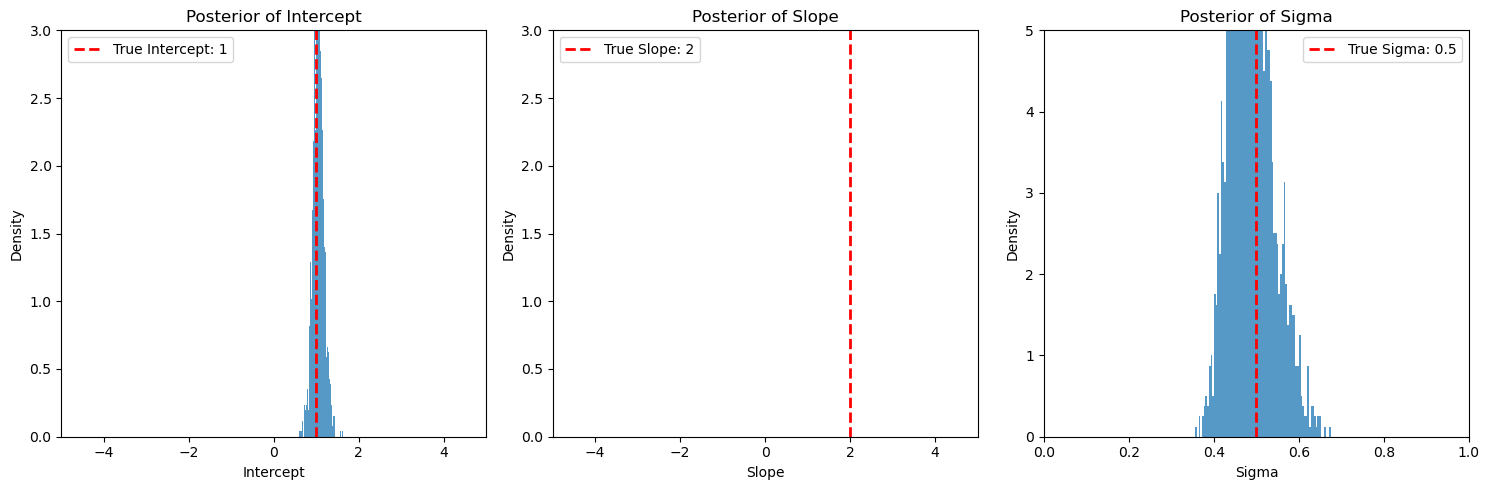

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot posterior for intercept
axes[0].hist(posterior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].axvline(
    TRUE_INTERCEPT,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Intercept: {TRUE_INTERCEPT}",
)
axes[0].set_title("Posterior of Intercept")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")
axes[0].set_xlim(left=-5, right=5)
axes[0].set_ylim(top=3, bottom=0)
axes[0].legend()

# Plot posterior for slope
axes[1].hist(posterior_samples["slopes"][0], bins=80, density=True, alpha=0.75)
axes[1].axvline(
    TRUE_SLOPES[0],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Slope: {TRUE_SLOPES[0]}",
)
axes[1].set_title("Posterior of Slope")
axes[1].set_xlabel("Slope")
axes[1].set_ylabel("Density")
axes[1].set_xlim(left=-5, right=5)
axes[1].set_ylim(top=3, bottom=0)
axes[1].legend()

# Plot posterior for sigma
axes[2].hist(posterior_samples["noise"], bins=80, density=True, alpha=0.75)
axes[2].axvline(
    TRUE_SIGMA,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Sigma: {TRUE_SIGMA}",
)
axes[2].set_title("Posterior of Sigma")
axes[2].set_xlabel("Sigma")
axes[2].set_ylabel("Density")
axes[2].set_xlim(left=0, right=1)
axes[2].set_ylim(top=5, bottom=0)
axes[2].legend()

plt.tight_layout()
plt.show()

We can make use of `get_posterior_summary()` to print out the summary statistics of our posterior.
Note the low values of the standard deviation - indicating the 'spikiness' of our distributions!

In [18]:
bayes_model.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.048,0.130,0.800,1.299,0.005,0.003,823.0,880.0,1.0
slopes[feature1],1.891,0.247,1.424,2.353,0.009,0.006,816.0,977.0,1.0
noise_var,0.239,0.049,0.160,0.339,0.002,0.001,950.0,873.0,1.0
noise,0.486,0.049,0.403,0.584,0.002,0.001,950.0,873.0,1.0


Additionally, note that apart from using the convenience functions provided by the BayesianLinearRegressor, such as `get_posterior_summary`, you can directly access the `idata` attribute of the model instance. This 'idata' object is a container for all inference data we've used on this model so far, including the training data, the prior and the posterior. 

Once you have the `idata` object, you can use the `arviz` library to analyze and visualize any distributions created during the model's lifetime, such as the prior and posterior distributions. `arviz` provides a rich set of tools for diagnostics, plotting, and summarizing the results of Bayesian models. This allows for a thorough examination of the model's behavior and the reliability of the inferred parameters.

For example, here, we use `arviz`'s `plot_posterior` to plot the posterior distribution of the `intercept ` variable.

<Axes: title={'center': 'intercept'}>

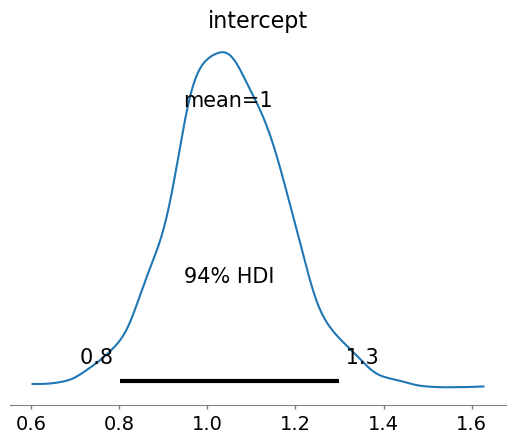

In [19]:
az.plot_posterior(bayes_model.idata, var_names="intercept")

# Model checking



Before using our Bayesian model to make predictions, it is advisable to perform some sanity checks to ascertain the correctness of the model set up and the assumptions. This section describes some of the most commonly used checks.

## `graphviz` Visualization

One way to understand the `bayes_model` is to visualize its composition using the `.visualize_model` method. This method uses the `graphviz` library to generate a graphical representation of the model, illustrating the relationships and dependencies between the priors, likelihood, data and the posterior.


The graphviz diagram will show the following:

- Ovals indicate stochastic nodes (random variables).
- Rectangles represent deterministic nodes (computed values).
- Shaded shapes (like the shaded ovals for X and y) indicate observed data or fixed inputs.
- Unshaded shapes represent latent variables or parameters that the model is trying to infer.

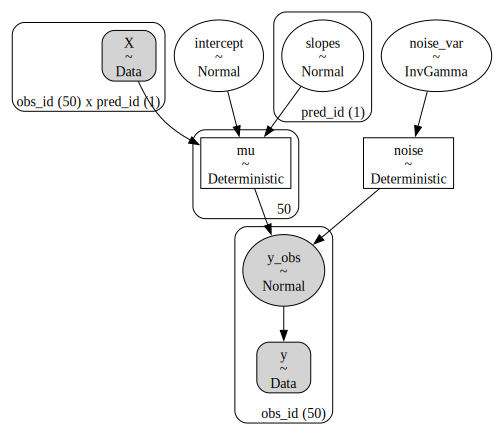

In [20]:
bayes_model.visualize_model()

## Posterior Predictive Check


A posterior predictive check (PPC), in general, is a method used to assess the fit of a Bayesian model by comparing observed data to data simulated from the model. It helps to identify discrepancies between the model predictions and the observed data, thereby providing a way to evaluate the adequacy of the model.

In our specific case, we'll use PPC to compare our target variable `y_train` versus the in-sample predictions (thin of it as `y_train_pred` generated by our model).

The `BayesianLinearRegressor` class provides a convenient method, `plot_ppc` to visually perform PPC.

The resulting plot will show the following components:

1. **Blue Lines**: represent the posterior predictive samples, which are the range of possible values that the model predicts for the observed data, given the posterior distribution of the parameters.

2. **Black Line**: represents the density of the observed data values (i.e. our `y_train`)

3. **Orange Dashed Line**: represents the mean of the posterior predictive distribution, whichprovides a central tendency of the model's predictions.

The plot is used to visually assess the goodness of fit of the Bayesian model. By comparing the observed data distribution (black line) to the mean of posterior predictive samples (orange dashed line), we can see if there are significant discrepancies. 

We can see below that the observed data closely follows the central tendency and falls within the range of the posterior predictive samples, suggesting a decent fit. 

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

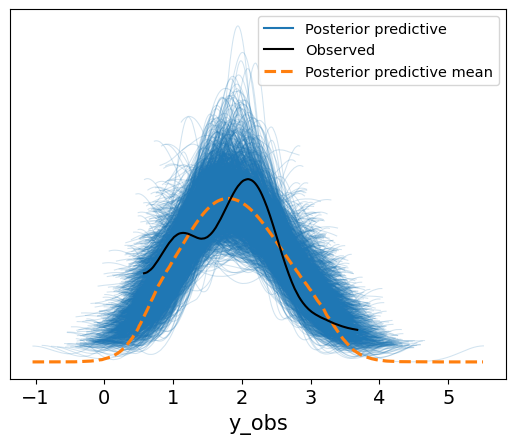

In [21]:
bayes_model.plot_ppc()

# Predictions

Now, it's time to use the trained `bayes_model` to perform out-of-sample prediction. As mentioned earlier, a significant benefit of using the Bayesian model is that it generates a full distribution for each test data point, rather than a single point estimate. This provides a more comprehensive understanding of the uncertainty and variability in the predictions.

In our class, this is accomplished using the `predict_proba` method, which returns an `skpro` `Empirical` distribution.


## `predict_proba`

In [22]:
y_pred_proba_bayes = bayes_model.predict_proba(X_test)

Sampling: [y_obs]


Output()

The returned distribution is known as the **posterior predictive distribution**. This distribution provides probabilistic forecasts for future observations by incorporating uncertainty about the model parameters and data variability.

The posterior predictive distribution enables us to make probabilistic statements about future observations and understand the variability in our predictions.



The posterior predictive distribution is given by:

$$
p(y_{\text{pred}} \mid X_{\text{new}}, X_{\text{train}}, y_{\text{train}}) = \int p(y_{\text{pred}} \mid X_{\text{new}}, \theta) p(\theta \mid X_{\text{train}}, y_{\text{train}}) \, d\theta
$$

where:
- $y_{\text{pred}}$ is the new predicted data point.
- $X_{\text{new}}$ is the new input.
- $\mathbf{X}_{\text{train}}$ is the set of observed inputs.
- $\mathbf{y}_{\text{train}}$ is the set of observed outputs.
- $\mathbf{\theta}$ represents the model parameters.
- $p(y_{\text{pred}} | X_{\text{new}}, \mathbf{\theta})$ is the likelihood of the new data point given the model parameters.
- $p(\mathbf{\theta} | \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$ is the posterior distribution of the model parameters given the observed data.

The above equation states that to obtain the distribution of the predictions $y_{\text{pred}}$, we need to perform two iterative sampling:

1. First, we sample from the posterior distribution $p(\theta \mid X_{\text{train}}, y_{\text{train}})$**

2. Afterwards, for each sampled $\theta$ from the posterior, we sample $y_{\text{pred}}$ from the predictive distribution $p(y_{\text{pred}} \mid X_{\text{new}}, \theta)$.

In practice, PyMC conveniently handles this sequential sampling process for us.

## `predict`

If point predictions are what we're after, we've got the `predict` method to do so. Internally, this `predict` method calls the `predict_proba` method above and averages the resulting posterior predictive distribution to provide a single point estimate for each test data point.

In [23]:
y_pred_bayes = bayes_model.predict(X_test)
y_pred_bayes.tail()

Sampling: [y_obs]


Output()

,target
obs_id,
25,2.676894
26,2.757779
27,2.797660
28,2.863926
29,2.942468


## `predict_quantiles`

The advantage of obtaining a full predictive distribution for our test set is that we can quantify our uncertainty by calculating quantiles. This can be conveniently achieved using the `predict_quantiles` method. Here, we use `predict_quantiles` to get the 25-th and 75-th percentiles of the posterior predictive distributions.

We'll then use these quantiles to plot our predictions together with their uncertainty.


In [24]:
y_pred_bayes_quantiles = bayes_model.predict_quantiles(X_test, [0.25, 0.75])
y_pred_bayes_quantiles.head()

Sampling: [y_obs]


Output()

target          
            0.25      0.75
obs_id                    
0       0.703573  1.381977
1       0.776732  1.431103
2       0.863144  1.536930
3       0.881808  1.575156
4       0.972508  1.645655

## `predict_interval`

Lastly, the model comes with the `predict_interval` method. This method returns the **credible interval**, which is a range within which a certain proportion of the posterior distribution lies. For example, a 95% credible interval for a parameter $\theta$ means that there is a 95% probability that $\theta$ lies within this interval, given the observed data and the prior distribution.

In [25]:
y_pred_bayes_interval = bayes_model.predict_interval(X_test, 0.95)
y_pred_bayes_interval.head()

Sampling: [y_obs]


Output()

target          
            0.95          
           lower     upper
obs_id                    
0       0.070566  2.019696
1       0.065008  2.071415
2       0.195635  2.171009
3       0.218097  2.255985
4       0.337108  2.357639

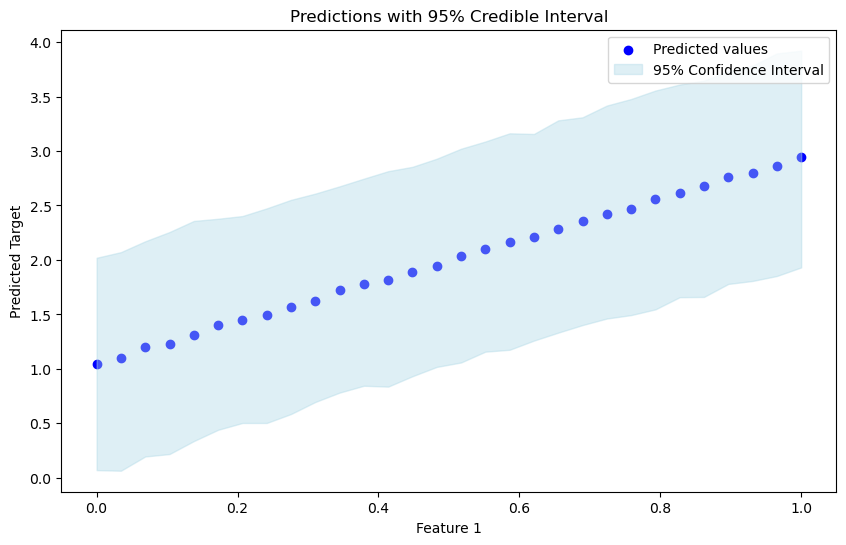

In [26]:
# Plot the predictions with the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test["feature1"], y_pred_bayes, color="blue", label="Predicted values")
plt.fill_between(
    X_test["feature1"],
    y_pred_bayes_interval["target"][0.95]["lower"],
    y_pred_bayes_interval["target"][0.95]["upper"],
    color="lightblue",
    alpha=0.4,
    label="95% Confidence Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title("Predictions with 95% Credible Interval")
plt.legend()
plt.show()

# Effect of Sample Size

Lastly, let's take a look at how the size of training sample affects the width of the posteriors and posterior predictive distributions.

## Posterior

Let's remind ourselves as to how our posterior distribution look like.

In [27]:
bayes_model.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.048,0.130,0.800,1.299,0.005,0.003,823.0,880.0,1.0
slopes[feature1],1.891,0.247,1.424,2.353,0.009,0.006,816.0,977.0,1.0
noise_var,0.239,0.049,0.160,0.339,0.002,0.001,950.0,873.0,1.0
noise,0.486,0.049,0.403,0.584,0.002,0.001,950.0,873.0,1.0


Now, let's generate a synthetic dataset with 500 (as opposed to 50) datapoints and use it to train another model.

In [28]:
N = 500

# Creating 500 random data points containing 1 feature
feature1 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1})

# Set the relationship between the feature and the target variable
TRUE_INTERCEPT = 1
TRUE_SLOPES = np.array([2])
TRUE_SIGMA = 0.5

# Calculating the true target variable
y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)
y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

bayes_model_500 = BayesianLinearRegressor()
bayes_model_500.fit(X_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/homebrew/Caskroom/miniforge/base/envs/pymc_env/lib/python3.12/site-packages/arviz/data/inference_data.py:1538: UserWarning: The group training_data is not defined in the InferenceData scheme
  warnings.warn(


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=0, sigma=10),
                                      'noise_var': Prior("InverseGamma", alpha=3, beta=1),
                                      'slopes': Prior("Normal", mu=0, sigma=10, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

We see that with this 10x increase in training set size, we obtain narrower posteriors, as evidenced by the lower `sd` values in the summary. It is noteworthy that the reduction of the standard deviation, which is around 3x, is less than the 10x reduction one might expect.

In [29]:
bayes_model_500.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.012,0.043,0.929,1.091,0.001,0.001,935.0,1032.0,1.0
slopes[feature1],1.971,0.077,1.822,2.109,0.003,0.002,885.0,947.0,1.0
noise_var,0.234,0.015,0.209,0.263,0.000,0.000,1217.0,997.0,1.0
noise,0.483,0.015,0.457,0.513,0.000,0.000,1217.0,997.0,1.0


In [30]:
sd_ratio = (
    bayes_model.get_posterior_summary() / bayes_model_500.get_posterior_summary()
)["sd"]
sd_ratio.name = "ratio of std dev when 10x training data is used"
sd_ratio

intercept           3.023256
slopes[feature1]    3.207792
noise_var           3.266667
noise               3.266667
Name: ratio of std dev when 10x training data is used, dtype: float64

## Posterior Predictive

Now, let's perform the same experiment, this time comparing the posterior predictive distribution coming from the two models.

In order to get the posterior predictive distribution from the second model (`bayes_model_500`), we first need to use it to perform prediction on the test set.

In [31]:
y_pred_proba_bayes_500 = bayes_model_500.predict_proba(X_test)

Sampling: [y_obs]


Output()

With that out of the way, let's now compare the posterior predictive distributions for both models.

In [32]:
az.summary(bayes_model.idata.predictions)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],1.042,0.501,0.138,1.971,0.012,0.009,1635.0,1848.0,1.0
y_obs[1],1.100,0.499,0.177,2.078,0.012,0.009,1663.0,1897.0,1.0
y_obs[2],1.202,0.510,0.255,2.148,0.012,0.008,1926.0,1851.0,1.0
y_obs[3],1.230,0.515,0.199,2.138,0.012,0.008,1933.0,1708.0,1.0
y_obs[4],1.314,0.512,0.338,2.248,0.012,0.008,1805.0,1897.0,1.0
y_obs[5],1.401,0.502,0.505,2.342,0.012,0.008,1884.0,1933.0,1.0
y_obs[6],1.451,0.501,0.521,2.348,0.012,0.008,1892.0,2051.0,1.0
y_obs[7],1.493,0.493,0.605,2.460,0.011,0.008,2073.0,1964.0,1.0
y_obs[8],1.570,0.500,0.648,2.521,0.011,0.008,1948.0,1924.0,1.0
y_obs[9],1.627,0.492,0.680,2.511,0.011,0.008,1927.0,1962.0,1.0


In [33]:
az.summary(bayes_model_500.idata.predictions)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],1.016,0.482,0.046,1.882,0.011,0.008,1861.0,1894.0,1.0
y_obs[1],1.076,0.486,0.138,1.952,0.012,0.008,1766.0,1667.0,1.0
y_obs[2],1.156,0.474,0.309,2.038,0.011,0.008,1953.0,1926.0,1.0
y_obs[3],1.207,0.478,0.285,2.082,0.011,0.008,2064.0,1986.0,1.0
y_obs[4],1.271,0.486,0.276,2.075,0.011,0.008,2064.0,1886.0,1.0
y_obs[5],1.355,0.484,0.455,2.268,0.011,0.008,2042.0,1898.0,1.0
y_obs[6],1.410,0.478,0.472,2.243,0.011,0.007,2056.0,2063.0,1.0
y_obs[7],1.485,0.488,0.531,2.368,0.011,0.008,2002.0,2003.0,1.0
y_obs[8],1.540,0.474,0.704,2.442,0.011,0.008,1885.0,1952.0,1.0
y_obs[9],1.620,0.489,0.689,2.504,0.011,0.008,2110.0,2050.0,1.0


We see that there is practically no difference in the standard deviation of the posterior predictive of both models.

In [34]:
(
    az.summary(bayes_model_500.idata.predictions)
    / az.summary(bayes_model.idata.predictions)
)[["sd"]]

,sd
y_obs[0],0.962076
y_obs[1],0.973948
y_obs[2],0.929412
y_obs[3],0.928155
y_obs[4],0.949219
y_obs[5],0.964143
y_obs[6],0.954092
y_obs[7],0.989858
y_obs[8],0.948000
y_obs[9],0.993902


# References

(WIP)

https://discourse.pymc.io/t/how-to-use-the-posterior-predictive-distribution-for-checking-a-model-from-pymc/11593/9

https://www.pymc.io/projects/docs/en/v5.15.1/api/generated/pymc.sample_prior_predictive.html

https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf